Adapted from the code for "Fine-tuning Deep Reinforcement Learning Policies with r-STDP for Domain Adaptation" by Akl et al., which can be found at https://github.com/mahmoudakl/dsrl/

# DQN vs. DSQN for the CartPole Environment

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import gym
import site
import torch
import random

import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt

site.addsitedir('cartpole_stuff/src/')

from datetime import date
# This is needed for some reason
from cartpole_stuff.src.model import QNetwork, DSNN
from cartpole_stuff.src.dqn_agent import Agent, ReplayBuffer
from matplotlib.gridspec import GridSpec

from backpropamine_DQN import RNetwork

%matplotlib inline

In [3]:
# Environment specific parameters
env_name = 'CartPole-v0'
n_runs = 5
n_evaluations = 100
max_steps = 200
num_episodes = 650

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
# Create Results Directory
dirs = os.listdir('.')
if not any('result' in d for d in dirs):
    result_id = 1
else:
    results = [d for d in dirs if 'result' in d]
    result_id = len(results) + 1

# Get today's date and add it to the results directory
d = date.today()
result_dir = 'dqn_result_' + str(result_id) + '_{}'.format(
    str(d.year) + str(d.month) + str(d.day))
os.mkdir(result_dir)
print('Created Directory {} to store the results in'.format(result_dir))

Created Directory dqn_result_19_2023107 to store the results in


In [5]:
# Hyperparameters
batch_size = 128
discount_factor = 0.999
eps_start = 1.0
eps_end = 0.05
eps_decay = 0.999
update_every = 4
target_update_frequency = 100
learning_rate = 0.001 # lr is 0.0001 for simple maze as default
l2_coef = 0 # 0 is default in simple maze task
replay_memory_size = 4*10**4
tau = 1e-3

In [6]:
# SNN Hyperparameters
simulation_time = 3
alpha = 0.5
beta = 0.5
threshold = 0.2
weight_scale = 1
architecture = [4, 64, 64, 2]

In [7]:
seeds = np.load('cartpole_stuff/seeds/training_seeds.npy')

## DQN Training

In [8]:
smoothed_scores_dqn_all = []
dqn_completion_after = []

for i_run in range(n_runs):
    print("Run # {}".format(i_run))
    seed = int(seeds[i_run])
    
    torch.manual_seed(seed)
    random.seed(seed)

    # policy_net = QNetwork(architecture, seed).to(device)
    # target_net = QNetwork(architecture, seed).to(device)
    policy_net = RNetwork(4, 64, 2, seed).to(device)
    target_net = RNetwork(4, 64, 2, seed).to(device)

    target_net.load_state_dict(policy_net.state_dict())

    # optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)
    optimizer = optim.Adam(policy_net.parameters(), lr = learning_rate, weight_decay = l2_coef) 
    agent = Agent(env_name, policy_net, target_net, architecture, batch_size,
                  replay_memory_size, discount_factor, eps_start, eps_end, eps_decay,
                  update_every, target_update_frequency, optimizer, learning_rate,
                  num_episodes, max_steps, i_run, result_dir, seed, tau)
    
    smoothed_scores, scores, best_average, best_average_after = agent.train_agent()

    np.save(result_dir + '/scores_{}'.format(i_run), scores)
    np.save(result_dir + '/smoothed_scores_DQN_{}'.format(i_run), smoothed_scores)

    # save smoothed scores in list to plot later
    dqn_completion_after.append(best_average_after)
    smoothed_scores_dqn_all.append(smoothed_scores)
    print("")

Run # 0


/home/luuk/Desktop/testing/.venv/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/luuk/Desktop/testing/.venv/lib/python3.8/site-packages/torch/nn/functional.py:1956: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Episode 100	Average Score: 17.14	 Epsilon: 0.18
Episode 200	Average Score: 45.01	 Epsilon: 0.05
Episode 300	Average Score: 83.72	 Epsilon: 0.05
Episode 400	Average Score: 158.57	 Epsilon: 0.05
Episode 500	Average Score: 197.39	 Epsilon: 0.05
Best 100 episode average:  199.03  reached at episode  468 . Model saved in folder best.

Run # 1
Episode 100	Average Score: 14.93	 Epsilon: 0.22
Episode 200	Average Score: 28.08	 Epsilon: 0.05
Episode 300	Average Score: 60.63	 Epsilon: 0.05
Episode 400	Average Score: 173.59	 Epsilon: 0.05
Episode 500	Average Score: 197.54	 Epsilon: 0.05
Best 100 episode average:  198.53  reached at episode  488 . Model saved in folder best.

Run # 2
Episode 100	Average Score: 21.03	 Epsilon: 0.12
Episode 200	Average Score: 38.79	 Epsilon: 0.05
Episode 300	Average Score: 109.70	 Epsilon: 0.05
Episode 400	Average Score: 198.91	 Epsilon: 0.05
Episode 500	Average Score: 198.51	 Epsilon: 0.05
Best 100 episode average:  199.7  reached at episode  426 . Model saved in fo

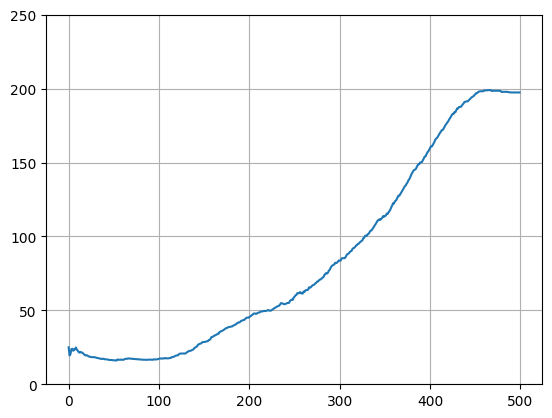

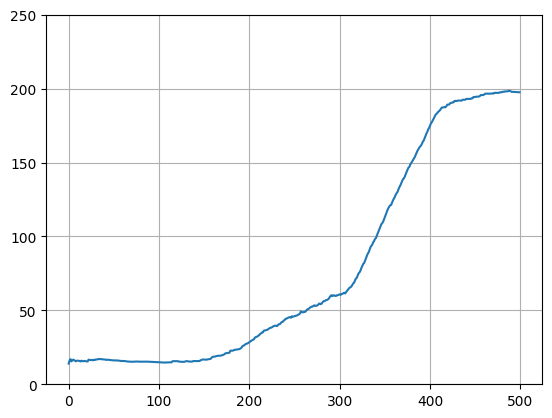

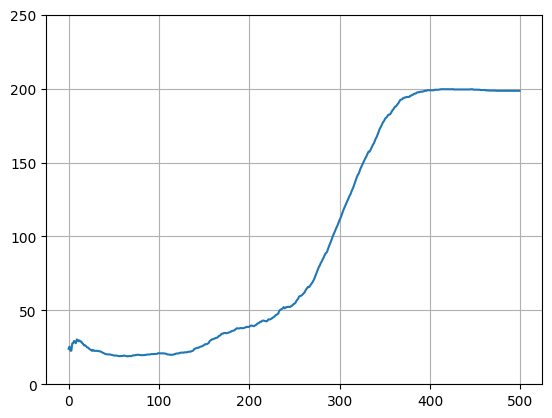

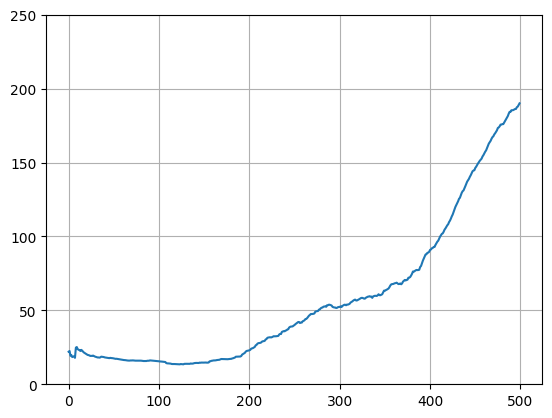

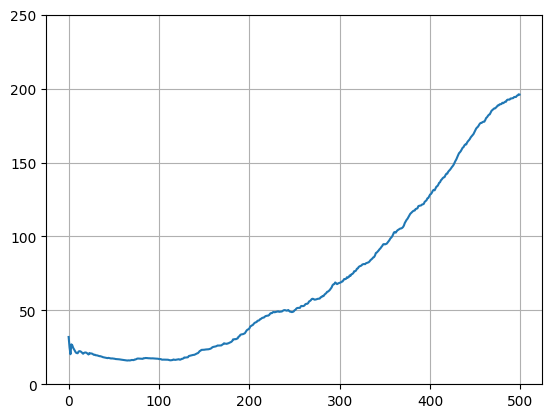

In [9]:
# Plot scores of individual runs
for i in range(len(smoothed_scores_dqn_all)):
    fig = plt.figure()
    plt.plot(smoothed_scores_dqn_all[i])
    plt.ylim(0, 250)
    plt.grid(True)
    plt.savefig(result_dir + '/training_dqn_{}.png'.format(i), dpi=1000)
    plt.show()

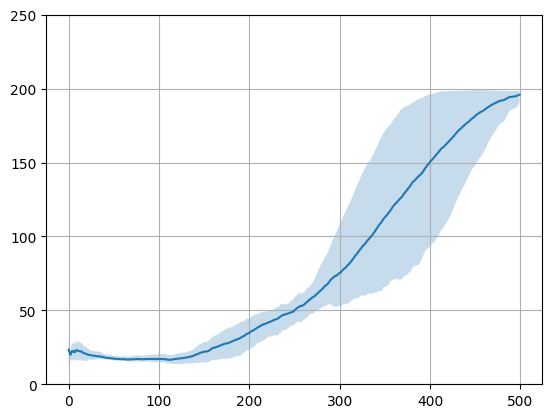

In [10]:
# Plot results (mean)
best_smoothed_scores_dqn = [smoothed_scores_dqn_all[0],
                            smoothed_scores_dqn_all[1],
                            smoothed_scores_dqn_all[2],
                            smoothed_scores_dqn_all[3],
                            smoothed_scores_dqn_all[4]]
mean_smoothed_scores_dqn = np.mean(best_smoothed_scores_dqn, axis=0)
std_smoothed_scores = np.std(best_smoothed_scores_dqn, axis=0)

avg_dqn_completion_after = np.mean([dqn_completion_after[0],
                                    dqn_completion_after[1],
                                    dqn_completion_after[2],
                                    dqn_completion_after[3],
                                    dqn_completion_after[4]])

fig = plt.figure()
plt.plot(range(len(best_smoothed_scores_dqn[0])), mean_smoothed_scores_dqn)
plt.fill_between(range(len(best_smoothed_scores_dqn[0])),
                 np.nanpercentile(best_smoothed_scores_dqn, 2, axis=0),
                 np.nanpercentile(best_smoothed_scores_dqn, 97, axis=0), alpha=0.25)
plt.ylim(0, 250)
plt.grid(True)
plt.savefig(result_dir + '/DQN_training.png', dpi=300)
plt.show()

## DSQN Training

In [31]:
smoothed_scores_dsqn_all = []
dsqn_completion_after = []

for i_run in range(n_runs):
    print("Run # {}".format(i_run))
    seed = int(seeds[i_run])

    torch.manual_seed(seed)
    random.seed(seed)

    policy_net = FFNetwork(4, 64, 64, 2)
    target_net = FFNetwork(4, 64, 64, 2)
    
    optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)

    agent = Agent(env_name, policy_net, target_net, architecture, batch_size,
                  replay_memory_size, discount_factor, eps_start, eps_end, eps_decay,
                  update_every, target_update_frequency, optimizer, learning_rate,
                  num_episodes, max_steps, i_run, result_dir, seed, tau, spiking=True)

    smoothed_scores, scores, best_average, best_average_after = agent.train_agent()

    np.save(result_dir + '/scores_{}'.format(i_run), scores)
    np.save(result_dir + '/smoothed_scores_DSQN_{}'.format(i_run), smoothed_scores)

    # save smoothed scores in list to plot later
    smoothed_scores_dsqn_all.append(smoothed_scores)
    dsqn_completion_after.append(best_average_after)
    print("")

Run # 0


TypeError: forward() missing 1 required positional argument: 'hebb'

In [ ]:
best_smoothed_scores_dsqn = [smoothed_scores_dsqn_all[0],
                             smoothed_scores_dsqn_all[1],
                             smoothed_scores_dsqn_all[2],
                             smoothed_scores_dsqn_all[3],
                             smoothed_scores_dsqn_all[4]]
mean_smoothed_scores_dsqn = np.mean(best_smoothed_scores_dsqn, axis=0)

avg_dsqn_completion_after = np.mean([dsqn_completion_after[0],
                                    dsqn_completion_after[1],
                                    dsqn_completion_after[2],
                                    dsqn_completion_after[3],
                                    dsqn_completion_after[4]])

fig = plt.figure()
plt.plot(range(len(best_smoothed_scores_dsqn[0])), mean_smoothed_scores_dsqn)
plt.fill_between(range(len(best_smoothed_scores_dsqn[0])),
                 np.nanpercentile(best_smoothed_scores_dsqn, 2, axis=0),
                 np.nanpercentile(best_smoothed_scores_dsqn, 97, axis=0), alpha=0.25)

plt.vlines(avg_dsqn_completion_after, 0, 250, 'C0')


plt.ylim(0, 250)
plt.grid(True)
plt.savefig(result_dir + '/DSQN_training.png', dpi=1000)
plt.title('CartPole-v0 DSQN')
plt.show()